In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

In [2]:
df_train = pd.read_csv('train_V2.csv', encoding='utf-8')
train_data = df_train.to_dict('records')
df_train.head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


## EDA

Group data by matchId.

In [3]:
match_idx_dict = defaultdict(lambda: [])

for i in range(len(train_data)):
    match_idx_dict[train_data[i]['matchId']].append(i) 

Match statistics.

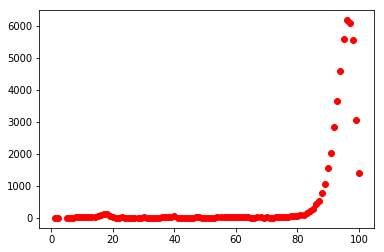

In [4]:
num_players_dict = defaultdict(int)
for indices in match_idx_dict.values():
    num_players_dict[len(indices)] += 1
    
plt.plot(num_players_dict.keys(), num_players_dict.values(), 'ro')

Take relevant columns to explore.

In [5]:
print(df_train.columns)

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')


In [6]:
rel_cols = set(df_train.columns)
rel_cols.remove('Id')
rel_cols.remove('groupId')
rel_cols.remove('matchId')
rel_cols.remove('matchType')
rel_cols.remove('roadKills')
rel_cols.remove('weaponsAcquired')

In [7]:
df_train_minimized = pd.DataFrame()
for c in rel_cols:
    df_train_minimized[c] = df_train[c]

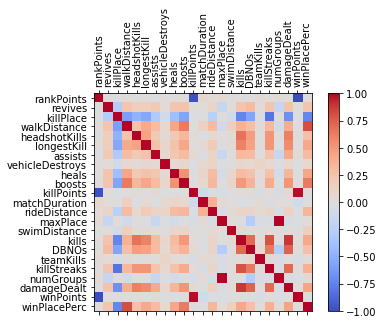

In [8]:
corr = df_train_minimized.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(df_train_minimized.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_train_minimized.columns)
ax.set_yticklabels(df_train_minimized.columns)
plt.show()

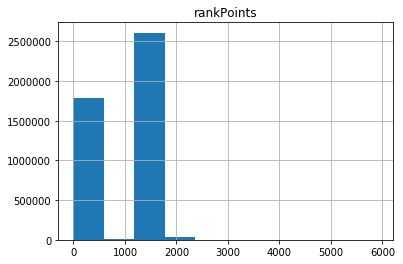

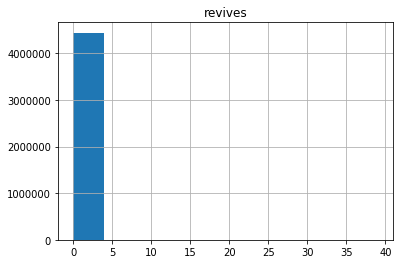

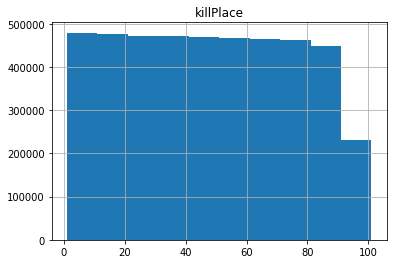

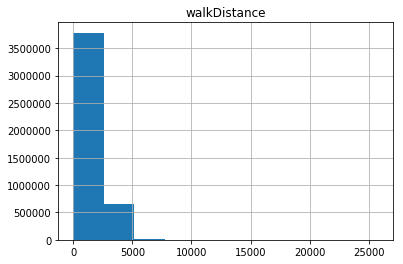

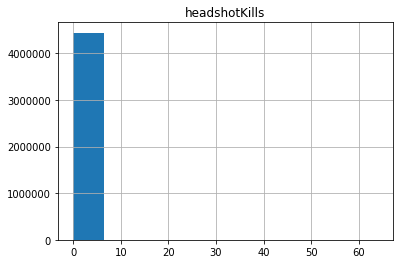

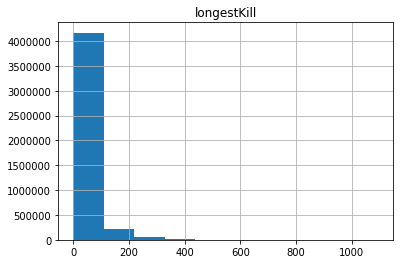

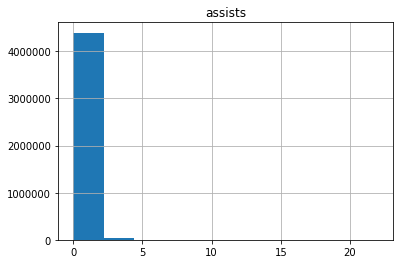

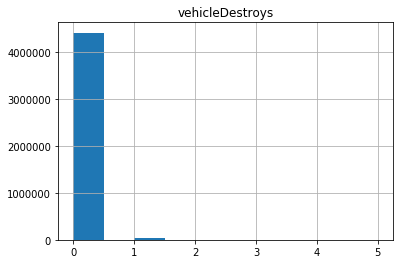

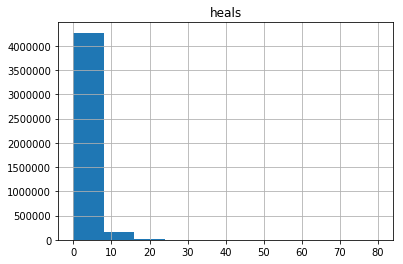

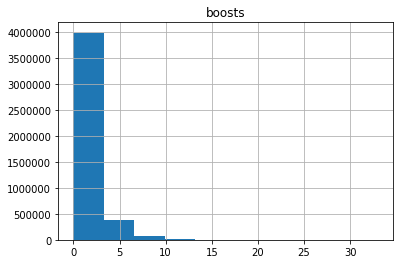

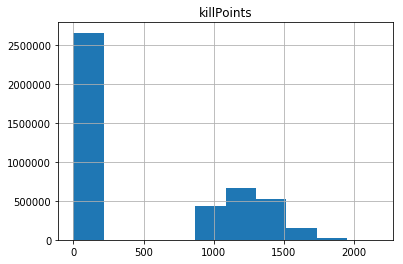

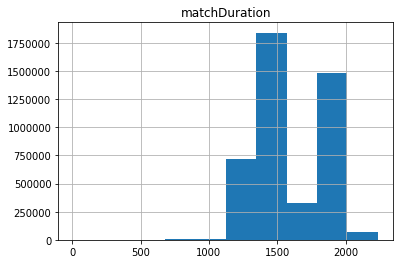

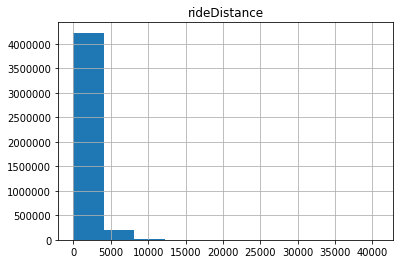

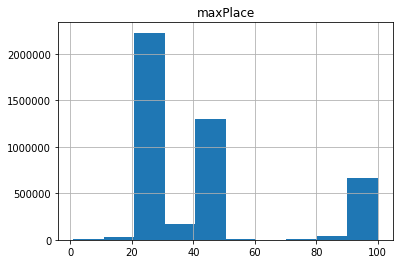

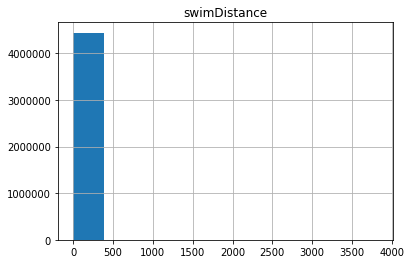

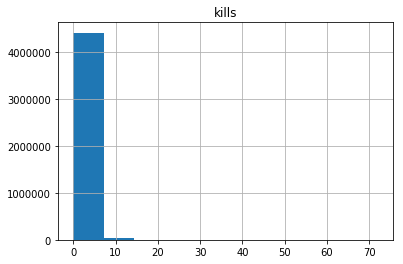

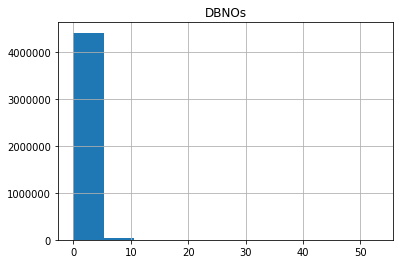

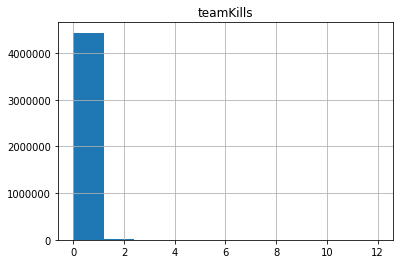

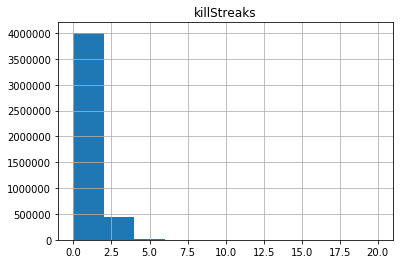

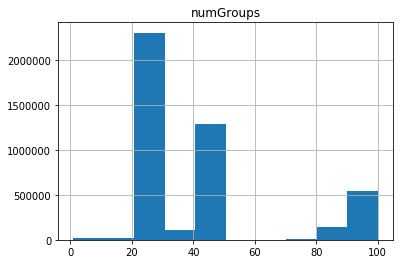

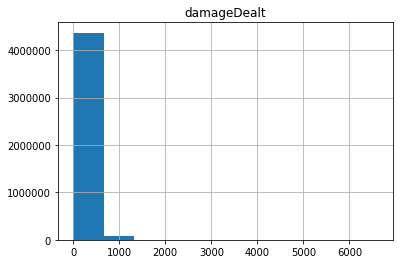

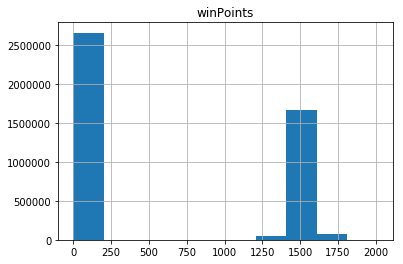

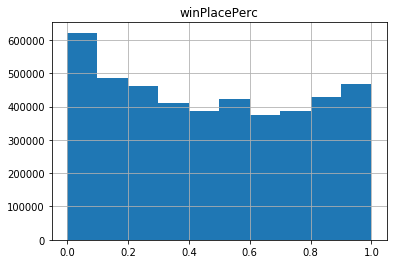

In [9]:
for c in rel_cols:
    df_train[c].hist()
    plt.title(c)
    plt.show()

Reduce range of x values so we can look at the data in more details.

In [10]:
df_train_set = pd.read_csv('train_set.csv', encoding='utf-8')
train_set = df_train_set.to_dict('records')

df_test_set = pd.read_csv('test_set.csv', encoding='utf-8')
test_set = df_test_set.to_dict('records')

df_valid_set = pd.read_csv('valid_set.csv', encoding='utf-8')
valid_set = df_valid_set.to_dict('records')

In [11]:
def fill_missing(data_set):
    for i in range(len(data_set)):
        if (np.isnan(data_set[i]['winPlacePerc'])):
            data_set[i]['winPlacePerc'] = 0
            
fill_missing(train_set)
fill_missing(test_set)
fill_missing(valid_set)

In [66]:
rel_cols = set(train_set[0].keys()) # Get columns
rel_cols.remove('Id')
rel_cols.remove('groupId')
rel_cols.remove('matchId')
#rel_cols.remove('matchType')
rel_cols.remove('roadKills')
rel_cols.remove('weaponsAcquired')
rel_cols.remove('winPlacePerc')
rel_cols.remove('Unnamed: 0')

In [78]:
matchTypes = ['solo', 'duo', 'squad', 'solo-fpp', 'duo-fpp', 'squad-fpp']
matchTypeID = defaultdict(int)
for i in range(len(matchTypes)):
    matchTypeID[matchTypes[i]] = i

def feature(datum):
    feature = []
    for c in rel_cols:
        if (c == 'matchType'):
            feature.append(matchTypeID[datum[c]])
        else:
            feature.append(datum[c])
    return feature

X_train = [feature(d) for d in train_set]
y_train = [d['winPlacePerc'] for d in train_set]

X_test = [feature(d) for d in test_set]
y_test = [d['winPlacePerc'] for d in test_set]

X_valid = [feature(d) for d in valid_set]
y_valid = [d['winPlacePerc'] for d in valid_set]

## Linear Regression

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [79]:
regr = LinearRegression()

# Train the model using the training sets
clf =regr.fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print "Score: ", score

y_pred = clf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)

('MAE: ', 0.09459229808877176)


In [ ]:
print clf.

In [ ]:
# For Kaggle
df_kaggle_set = pd.read_csv('test_V2.csv', encoding='utf-8')
kaggle_set = df_kaggle_set.to_dict('records')

In [73]:
print "Started preparing submission file"

X_kaggle = [feature(d) for d in kaggle_set]
ids_kaggle = [d['Id']for d in kaggle_set]

predictions = clf.predict(X_kaggle)

print "Prediction ready"

Started preparing submission file
Prediction ready


In [74]:
print "Writing output file"

f = open("test_y.csv", "w")
f.write("Id,winPlacePerc\n")
for i in range(len(predictions)):
    id_kaggle = ids_kaggle[i]
    w = str(id_kaggle) + "," + str(predictions[i]) + "\n"
    f.write(w)
f.close()

print "Submission file is ready."

Writing output file
Submission file is ready.


## LightGBM

In [14]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [129]:
import datetime

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l2', 'l1'},
    'num_leaves': 350,
    'max_bin': 350,
    'num_iterations': 1000,
    'learning_rate': 0.05,
    'num_threads': 2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print(datetime.datetime.now())

lgb_data = lgb.Dataset(X_train, y_train)
lgb_train = lgb.train(params, lgb_data)
predictions = lgb_train.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print "MAE: ", mae

print(datetime.datetime.now())

2018-12-02 23:23:01.818659
MAE:  0.05740189677061773
2018-12-02 23:34:56.911968


In [193]:
xlabels = list(rel_cols)
def columnNameToName(s):
    s = str(s.get_text())
    index = s.split("_")[1]
    return xlabels[ int(index) ]

[]

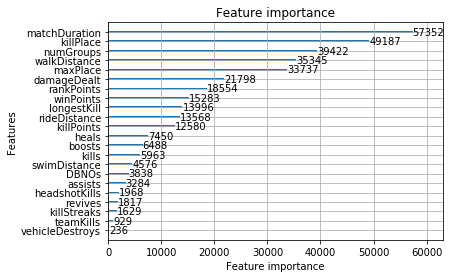

In [197]:
subplot = lightgbm.plot_importance(lgb_train)
subplot.axes.set_yticklabels( [columnNameToName(s) for s in subplot.axes.get_yticklabels()] )
subplot.plot()

In [109]:
# For Kaggle
df_kaggle_set = pd.read_csv('test_V2.csv', encoding='utf-8')
kaggle_set = df_kaggle_set.to_dict('records')

In [110]:
print "Started preparing submission file"

X_kaggle = [feature(d) for d in kaggle_set]
ids_kaggle = [d['Id']for d in kaggle_set]

predictions = lgb_train.predict(X_kaggle)

print "Prediction ready"

Started preparing submission file
Prediction ready


In [111]:
print "Writing output file"

f = open("test_y.csv", "w")
f.write("Id,winPlacePerc\n")
for i in range(len(predictions)):
    id_kaggle = ids_kaggle[i]
    w = str(id_kaggle) + "," + str(predictions[i]) + "\n"
    f.write(w)
f.close()

print "Submission file is ready."

Writing output file
Submission file is ready.


## CatBoost

In [113]:
import catboost

In [137]:
model = catboost.CatBoostRegressor(iterations=1200, depth=10, learning_rate=0.05, loss_function='MAE')
model.fit(X_train, y_train)

0:	learn: 0.4510775	total: 582ms	remaining: 11m 37s
1:	learn: 0.4285785	total: 1.19s	remaining: 11m 55s
2:	learn: 0.4077904	total: 1.79s	remaining: 11m 52s
3:	learn: 0.3875677	total: 2.38s	remaining: 11m 51s
4:	learn: 0.3682325	total: 2.94s	remaining: 11m 43s
5:	learn: 0.3497470	total: 3.44s	remaining: 11m 24s
6:	learn: 0.3319446	total: 3.91s	remaining: 11m 7s
7:	learn: 0.3146820	total: 4.37s	remaining: 10m 51s
8:	learn: 0.2981850	total: 4.93s	remaining: 10m 52s
9:	learn: 0.2822997	total: 5.65s	remaining: 11m 11s
10:	learn: 0.2670744	total: 6.13s	remaining: 11m 2s
11:	learn: 0.2524594	total: 6.59s	remaining: 10m 52s
12:	learn: 0.2383111	total: 7.18s	remaining: 10m 55s
13:	learn: 0.2247697	total: 7.68s	remaining: 10m 51s
14:	learn: 0.2118286	total: 8.15s	remaining: 10m 43s
15:	learn: 0.1994194	total: 8.71s	remaining: 10m 44s
16:	learn: 0.1876760	total: 9.53s	remaining: 11m 3s
17:	learn: 0.1764261	total: 10.4s	remaining: 11m 22s
18:	learn: 0.1657955	total: 11s	remaining: 11m 23s
19:	lear

155:	learn: 0.0585214	total: 1m 27s	remaining: 9m 43s
156:	learn: 0.0585188	total: 1m 27s	remaining: 9m 42s
157:	learn: 0.0585099	total: 1m 28s	remaining: 9m 41s
158:	learn: 0.0585016	total: 1m 28s	remaining: 9m 40s
159:	learn: 0.0584868	total: 1m 29s	remaining: 9m 39s
160:	learn: 0.0584890	total: 1m 29s	remaining: 9m 39s
161:	learn: 0.0584865	total: 1m 30s	remaining: 9m 38s
162:	learn: 0.0584894	total: 1m 30s	remaining: 9m 37s
163:	learn: 0.0584883	total: 1m 31s	remaining: 9m 36s
164:	learn: 0.0584871	total: 1m 31s	remaining: 9m 35s
165:	learn: 0.0584796	total: 1m 32s	remaining: 9m 35s
166:	learn: 0.0584796	total: 1m 32s	remaining: 9m 33s
167:	learn: 0.0584717	total: 1m 34s	remaining: 9m 38s
168:	learn: 0.0584632	total: 1m 35s	remaining: 9m 41s
169:	learn: 0.0584637	total: 1m 36s	remaining: 9m 41s
170:	learn: 0.0584560	total: 1m 36s	remaining: 9m 41s
171:	learn: 0.0584357	total: 1m 37s	remaining: 9m 40s
172:	learn: 0.0584191	total: 1m 38s	remaining: 9m 42s
173:	learn: 0.0584125	total:

308:	learn: 0.0576004	total: 2m 48s	remaining: 8m 5s
309:	learn: 0.0575784	total: 2m 49s	remaining: 8m 5s
310:	learn: 0.0575747	total: 2m 50s	remaining: 8m 6s
311:	learn: 0.0575671	total: 2m 50s	remaining: 8m 5s
312:	learn: 0.0575622	total: 2m 51s	remaining: 8m 5s
313:	learn: 0.0575547	total: 2m 51s	remaining: 8m 4s
314:	learn: 0.0575445	total: 2m 52s	remaining: 8m 4s
315:	learn: 0.0575366	total: 2m 52s	remaining: 8m 3s
316:	learn: 0.0575239	total: 2m 53s	remaining: 8m 2s
317:	learn: 0.0575195	total: 2m 53s	remaining: 8m 2s
318:	learn: 0.0575121	total: 2m 54s	remaining: 8m 1s
319:	learn: 0.0575077	total: 2m 54s	remaining: 8m
320:	learn: 0.0575015	total: 2m 55s	remaining: 7m 59s
321:	learn: 0.0574960	total: 2m 55s	remaining: 7m 59s
322:	learn: 0.0574853	total: 2m 56s	remaining: 7m 58s
323:	learn: 0.0574797	total: 2m 56s	remaining: 7m 57s
324:	learn: 0.0574638	total: 2m 57s	remaining: 7m 56s
325:	learn: 0.0574522	total: 2m 57s	remaining: 7m 55s
326:	learn: 0.0574419	total: 2m 57s	remaini

462:	learn: 0.0569508	total: 4m 3s	remaining: 6m 28s
463:	learn: 0.0569506	total: 4m 4s	remaining: 6m 27s
464:	learn: 0.0569458	total: 4m 4s	remaining: 6m 27s
465:	learn: 0.0569466	total: 4m 5s	remaining: 6m 26s
466:	learn: 0.0569474	total: 4m 5s	remaining: 6m 25s
467:	learn: 0.0569475	total: 4m 6s	remaining: 6m 25s
468:	learn: 0.0569460	total: 4m 6s	remaining: 6m 24s
469:	learn: 0.0569447	total: 4m 7s	remaining: 6m 23s
470:	learn: 0.0569430	total: 4m 7s	remaining: 6m 23s
471:	learn: 0.0569418	total: 4m 8s	remaining: 6m 22s
472:	learn: 0.0569383	total: 4m 8s	remaining: 6m 21s
473:	learn: 0.0569379	total: 4m 8s	remaining: 6m 21s
474:	learn: 0.0569355	total: 4m 9s	remaining: 6m 20s
475:	learn: 0.0569329	total: 4m 9s	remaining: 6m 19s
476:	learn: 0.0569338	total: 4m 10s	remaining: 6m 19s
477:	learn: 0.0569313	total: 4m 10s	remaining: 6m 18s
478:	learn: 0.0569324	total: 4m 11s	remaining: 6m 18s
479:	learn: 0.0569303	total: 4m 11s	remaining: 6m 17s
480:	learn: 0.0569314	total: 4m 12s	remain

616:	learn: 0.0561733	total: 5m 13s	remaining: 4m 56s
617:	learn: 0.0561699	total: 5m 14s	remaining: 4m 56s
618:	learn: 0.0561673	total: 5m 15s	remaining: 4m 55s
619:	learn: 0.0561626	total: 5m 15s	remaining: 4m 55s
620:	learn: 0.0561582	total: 5m 16s	remaining: 4m 54s
621:	learn: 0.0561546	total: 5m 16s	remaining: 4m 54s
622:	learn: 0.0561513	total: 5m 17s	remaining: 4m 53s
623:	learn: 0.0561494	total: 5m 17s	remaining: 4m 53s
624:	learn: 0.0561423	total: 5m 17s	remaining: 4m 52s
625:	learn: 0.0561390	total: 5m 18s	remaining: 4m 51s
626:	learn: 0.0561347	total: 5m 18s	remaining: 4m 51s
627:	learn: 0.0561321	total: 5m 19s	remaining: 4m 50s
628:	learn: 0.0561294	total: 5m 19s	remaining: 4m 50s
629:	learn: 0.0561284	total: 5m 20s	remaining: 4m 49s
630:	learn: 0.0561255	total: 5m 20s	remaining: 4m 49s
631:	learn: 0.0561171	total: 5m 21s	remaining: 4m 48s
632:	learn: 0.0561042	total: 5m 21s	remaining: 4m 47s
633:	learn: 0.0560989	total: 5m 21s	remaining: 4m 47s
634:	learn: 0.0560918	total:

769:	learn: 0.0551056	total: 6m 31s	remaining: 3m 38s
770:	learn: 0.0550990	total: 6m 31s	remaining: 3m 37s
771:	learn: 0.0550949	total: 6m 32s	remaining: 3m 37s
772:	learn: 0.0550841	total: 6m 32s	remaining: 3m 36s
773:	learn: 0.0550813	total: 6m 33s	remaining: 3m 36s
774:	learn: 0.0550766	total: 6m 33s	remaining: 3m 35s
775:	learn: 0.0550712	total: 6m 34s	remaining: 3m 35s
776:	learn: 0.0550693	total: 6m 34s	remaining: 3m 34s
777:	learn: 0.0550643	total: 6m 35s	remaining: 3m 34s
778:	learn: 0.0550574	total: 6m 35s	remaining: 3m 33s
779:	learn: 0.0550480	total: 6m 36s	remaining: 3m 33s
780:	learn: 0.0550420	total: 6m 36s	remaining: 3m 32s
781:	learn: 0.0550384	total: 6m 37s	remaining: 3m 32s
782:	learn: 0.0550368	total: 6m 37s	remaining: 3m 31s
783:	learn: 0.0550359	total: 6m 38s	remaining: 3m 31s
784:	learn: 0.0550301	total: 6m 38s	remaining: 3m 30s
785:	learn: 0.0550218	total: 6m 39s	remaining: 3m 30s
786:	learn: 0.0550179	total: 6m 39s	remaining: 3m 29s
787:	learn: 0.0550145	total:

922:	learn: 0.0543140	total: 7m 51s	remaining: 2m 21s
923:	learn: 0.0543041	total: 7m 52s	remaining: 2m 21s
924:	learn: 0.0542958	total: 7m 52s	remaining: 2m 20s
925:	learn: 0.0542927	total: 7m 53s	remaining: 2m 19s
926:	learn: 0.0542884	total: 7m 53s	remaining: 2m 19s
927:	learn: 0.0542790	total: 7m 54s	remaining: 2m 19s
928:	learn: 0.0542770	total: 7m 54s	remaining: 2m 18s
929:	learn: 0.0542723	total: 7m 55s	remaining: 2m 18s
930:	learn: 0.0542657	total: 7m 55s	remaining: 2m 17s
931:	learn: 0.0542635	total: 7m 56s	remaining: 2m 17s
932:	learn: 0.0542559	total: 7m 56s	remaining: 2m 16s
933:	learn: 0.0542537	total: 7m 57s	remaining: 2m 15s
934:	learn: 0.0542438	total: 7m 57s	remaining: 2m 15s
935:	learn: 0.0542389	total: 7m 58s	remaining: 2m 14s
936:	learn: 0.0542323	total: 7m 58s	remaining: 2m 14s
937:	learn: 0.0542269	total: 7m 59s	remaining: 2m 13s
938:	learn: 0.0542218	total: 7m 59s	remaining: 2m 13s
939:	learn: 0.0542193	total: 8m	remaining: 2m 12s
940:	learn: 0.0542108	total: 8m	

1074:	learn: 0.0535972	total: 9m 10s	remaining: 1m 3s
1075:	learn: 0.0535948	total: 9m 10s	remaining: 1m 3s
1076:	learn: 0.0535939	total: 9m 11s	remaining: 1m 2s
1077:	learn: 0.0535923	total: 9m 11s	remaining: 1m 2s
1078:	learn: 0.0535852	total: 9m 12s	remaining: 1m 1s
1079:	learn: 0.0535828	total: 9m 12s	remaining: 1m 1s
1080:	learn: 0.0535815	total: 9m 13s	remaining: 1m
1081:	learn: 0.0535751	total: 9m 13s	remaining: 1m
1082:	learn: 0.0535743	total: 9m 14s	remaining: 59.9s
1083:	learn: 0.0535728	total: 9m 14s	remaining: 59.4s
1084:	learn: 0.0535720	total: 9m 15s	remaining: 58.9s
1085:	learn: 0.0535675	total: 9m 15s	remaining: 58.3s
1086:	learn: 0.0535649	total: 9m 16s	remaining: 57.8s
1087:	learn: 0.0535631	total: 9m 16s	remaining: 57.3s
1088:	learn: 0.0535612	total: 9m 17s	remaining: 56.8s
1089:	learn: 0.0535577	total: 9m 17s	remaining: 56.3s
1090:	learn: 0.0535559	total: 9m 18s	remaining: 55.7s
1091:	learn: 0.0535528	total: 9m 18s	remaining: 55.2s
1092:	learn: 0.0535519	total: 9m 1

In [138]:
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print "MAE: ", mae

MAE:  0.058681543471845586


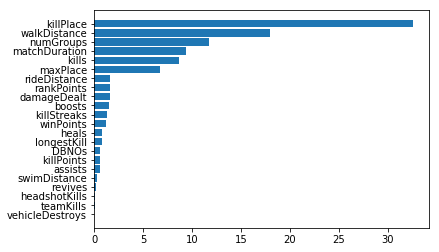

In [267]:
xVal = model.get_feature_importance()
yVal = [k for k in rel_cols]
comVal = list(zip(xVal, yVal))
comVal = sorted(comVal, key = lambda k: k[0])
xVal, yVal = zip(*comVal)

pt = plt.barh(yVal, xVal)